In [46]:
import pandas as pd
import matplotlib as plt

In [47]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
query_frame = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Query.csv',sep=";")
#train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic+Data.csv', sep = ";", decimal=',')
query_frame

,count(event),hour_,Unnamed: 2,Unnamed: 3
0,51,09.06.2022 18:00,NaN,NaN
1,185,09.06.2022 19:00,NaN,NaN
2,136,09.06.2022 20:00,NaN,NaN
3,132,09.06.2022 21:00,NaN,NaN
4,93,09.06.2022 22:00,NaN,NaN
...,...,...,...,...
1249,72,31.07.2022 19:00,NaN,NaN
1250,66,31.07.2022 20:00,NaN,NaN
1251,53,31.07.2022 21:00,NaN,NaN
1252,56,31.07.2022 22:00,NaN,NaN


In [50]:
query_frame=query_frame.drop(columns=['Unnamed: 2'], axis=1)
query_frame=query_frame.drop(columns=['Unnamed: 3'], axis=1)

In [51]:
query_frame=query_frame[6:]

In [52]:
query_frame

,count(event),hour_
6,56,10.06.2022 0:00
7,27,10.06.2022 1:00
8,25,10.06.2022 2:00
9,24,10.06.2022 3:00
10,20,10.06.2022 4:00
...,...,...
1249,72,31.07.2022 19:00
1250,66,31.07.2022 20:00
1251,53,31.07.2022 21:00
1252,56,31.07.2022 22:00


In [53]:
#query_frame = pd.read_csv('New_Query.txt')

In [54]:
main_data = query_frame['count(event)'].values.astype(float)

In [55]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 25
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

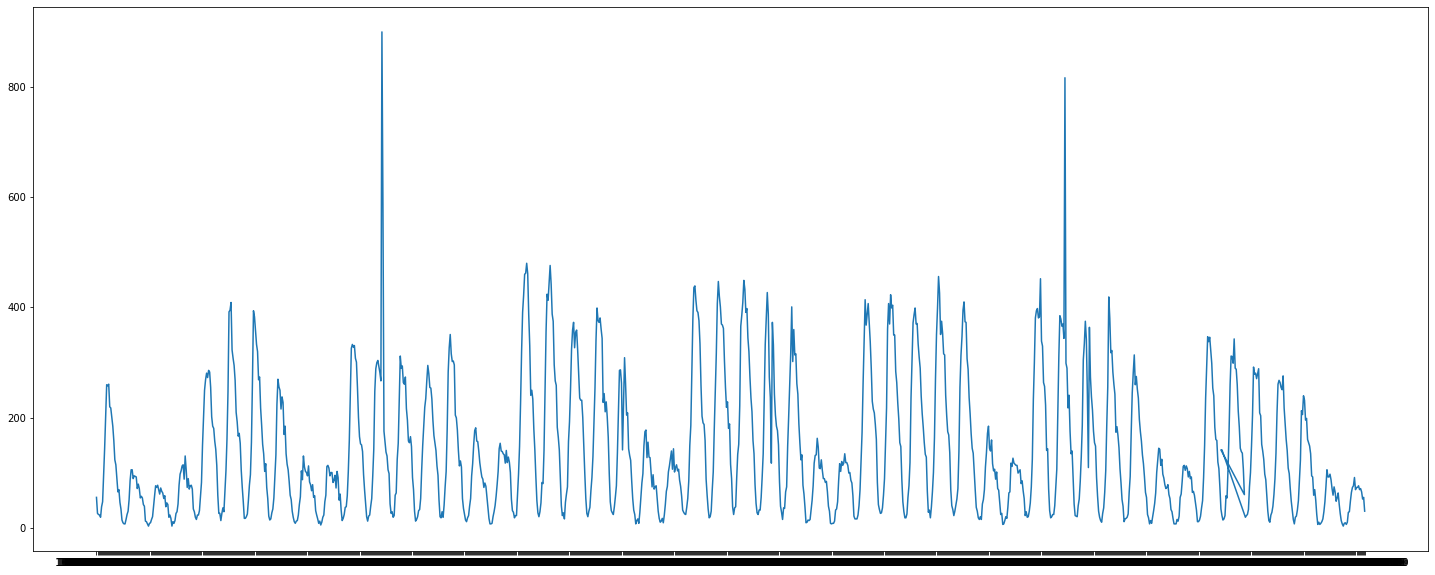

In [56]:
x = query_frame['hour_']
y = query_frame['count(event)'] 
plt.plot(x, y)
plt.show()

In [57]:
test_data_size = 24

train_data = main_data[:-test_data_size]
test_data = main_data[-test_data_size:]

In [58]:
print(len(train_data))
print(len(test_data))

1224
24


In [59]:
print(test_data)

[14.  8.  4.  9. 10.  7. 11. 29. 30. 49. 65. 74. 77. 92. 70. 74. 74. 77.
 70. 72. 66. 53. 56. 31.]


In [60]:
# нормализация
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(-1, 1))
y = y.values.reshape(-1,1)
train_data_normalized = scaler.fit_transform(y)

In [61]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized

tensor([-0.8838, -0.9486, -0.9531,  ..., -0.8905, -0.8838, -0.9397])

In [62]:

# функция для создания кортежей из 24 элементов
def window(data, nw):
    sequences=[]
    length_seq=len(data)
    for i in range(length_seq-nw):
        train_seq = data[i:i+nw]
        train_mark = data[i+nw:i+nw+1]
        sequences.append((train_seq, train_mark))
    return sequences

In [63]:
# создаём последовательности
train_sequences = window(train_data_normalized,test_data_size)

In [64]:
train_sequences[:2]

[(tensor([-0.8838, -0.9486, -0.9531, -0.9553, -0.9642, -0.9218, -0.9017, -0.7989,
          -0.6849, -0.5553, -0.4279, -0.4324, -0.4257, -0.5173, -0.5218, -0.5575,
          -0.5955, -0.6536, -0.7318, -0.7520, -0.8078, -0.8615, -0.8525, -0.9039]),
  tensor([-0.9307])),
 (tensor([-0.9486, -0.9531, -0.9553, -0.9642, -0.9218, -0.9017, -0.7989, -0.6849,
          -0.5553, -0.4279, -0.4324, -0.4257, -0.5173, -0.5218, -0.5575, -0.5955,
          -0.6536, -0.7318, -0.7520, -0.8078, -0.8615, -0.8525, -0.9039, -0.9307]),
  tensor([-0.9754]))]

In [65]:
# LSTM
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size)) # (num_layers * num_directions, batch_size, hidden_size)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [66]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [67]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [68]:
epochs = 50

for i in range(epochs):
    for seq, labels in train_sequences:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.00143616
epoch:   1 loss: 0.00032023
epoch:   2 loss: 0.00264356
epoch:   3 loss: 0.00147248
epoch:   4 loss: 0.00181494
epoch:   5 loss: 0.00191819
epoch:   6 loss: 0.00289515
epoch:   7 loss: 0.00326564
epoch:   8 loss: 0.00297076
epoch:   9 loss: 0.00250749
epoch:  10 loss: 0.00218257
epoch:  11 loss: 0.00201309
epoch:  12 loss: 0.00188500
epoch:  13 loss: 0.00176960
epoch:  14 loss: 0.00169285
epoch:  15 loss: 0.00161433
epoch:  16 loss: 0.00168343
epoch:  17 loss: 0.00135248
epoch:  18 loss: 0.00096651
epoch:  19 loss: 0.00112956
epoch:  20 loss: 0.00072572
epoch:  21 loss: 0.00059020
epoch:  22 loss: 0.00028054
epoch:  23 loss: 0.00043957
epoch:  24 loss: 0.00044571
epoch:  25 loss: 0.00067145
epoch:  26 loss: 0.00089025
epoch:  27 loss: 0.00116455
epoch:  28 loss: 0.00070768
epoch:  29 loss: 0.00070059
epoch:  30 loss: 0.00088122
epoch:  31 loss: 0.00088706
epoch:  32 loss: 0.00101443
epoch:  33 loss: 0.00078006
epoch:  34 loss: 0.00063259
epoch:  35 loss: 0.0

In [77]:
preds= 24
test_inputs=train_data_normalized[-test_data_size:].tolist()

In [70]:
test_inputs

[-0.9776536226272583,
 -0.9910614490509033,
 -1.0,
 -0.9888268113136292,
 -0.986592173576355,
 -0.9932960867881775,
 -0.9843575358390808,
 -0.9441340565681458,
 -0.9418994188308716,
 -0.8994413614273071,
 -0.8636871576309204,
 -0.8435754179954529,
 -0.8368715047836304,
 -0.8033519387245178,
 -0.8525139689445496,
 -0.8435754179954529,
 -0.8435754179954529,
 -0.8368715047836304,
 -0.8525139689445496,
 -0.8480446934700012,
 -0.8614525198936462,
 -0.8905028104782104,
 -0.8837988972663879,
 -0.9396647810935974]

In [71]:
test_data

array([14.,  8.,  4.,  9., 10.,  7., 11., 29., 30., 49., 65., 74., 77.,
       92., 70., 74., 74., 77., 70., 72., 66., 53., 56., 31.])

In [72]:
win=24

In [73]:
model.eval()

for i in range(len(test_data)):
    seq = torch.FloatTensor(test_inputs[-win:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [74]:
test_inputs[win:]

[-0.9473937749862671,
 -0.9724702835083008,
 -0.9981528520584106,
 -1.016635775566101,
 -1.0355796813964844,
 -1.049451231956482,
 -1.0601396560668945,
 -1.070120096206665,
 -1.076069951057434,
 -1.0792806148529053,
 -1.0768994092941284,
 -1.0667182207107544,
 -1.0483694076538086,
 -1.0224275588989258,
 -0.9828509092330933,
 -0.9080430269241333,
 -0.8692525625228882,
 -0.856187105178833,
 -0.8084625005722046,
 -0.7924810647964478,
 -0.7874000072479248,
 -0.7496601343154907,
 -0.6998413801193237,
 -0.7287899255752563]

In [75]:
actual_predictions= scaler.inverse_transform(np.array(test_inputs[win:]).reshape(-1,1))

In [98]:
pred_meanings =actual_predictions

In [99]:
fig_size2 = plt.rcParams["figure.figsize"]
fig_size2[0] = 25
fig_size2[1] = 10
plt.rcParams["figure.figsize"] = fig_size2

In [92]:
test_data

array([14.,  8.,  4.,  9., 10.,  7., 11., 29., 30., 49., 65., 74., 77.,
       92., 70., 74., 74., 77., 70., 72., 66., 53., 56., 31.])

In [100]:
query_frame['hour_'][-24:]

1230     31.07.2022 0:00
1231     31.07.2022 1:00
1232     31.07.2022 2:00
1233     31.07.2022 3:00
1234     31.07.2022 4:00
1235     31.07.2022 5:00
1236     31.07.2022 6:00
1237     31.07.2022 7:00
1238     31.07.2022 8:00
1239     31.07.2022 9:00
1240    31.07.2022 10:00
1241    31.07.2022 11:00
1242    31.07.2022 12:00
1243    31.07.2022 13:00
1244    31.07.2022 14:00
1245    31.07.2022 15:00
1246    31.07.2022 16:00
1247    31.07.2022 17:00
1248    31.07.2022 18:00
1249    31.07.2022 19:00
1250    31.07.2022 20:00
1251    31.07.2022 21:00
1252    31.07.2022 22:00
1253    31.07.2022 23:00
Name: hour_, dtype: object

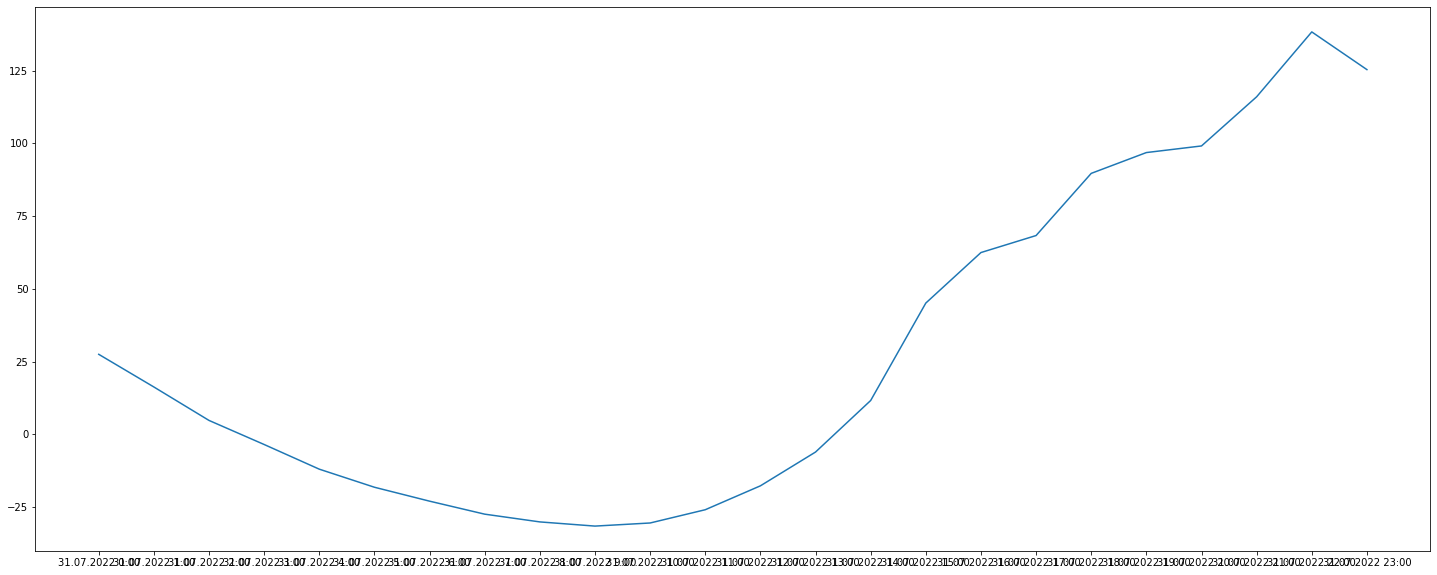

In [101]:
x = query_frame['hour_'][-24:]
y = pred_meanings
plt.plot(x, y)
plt.show()

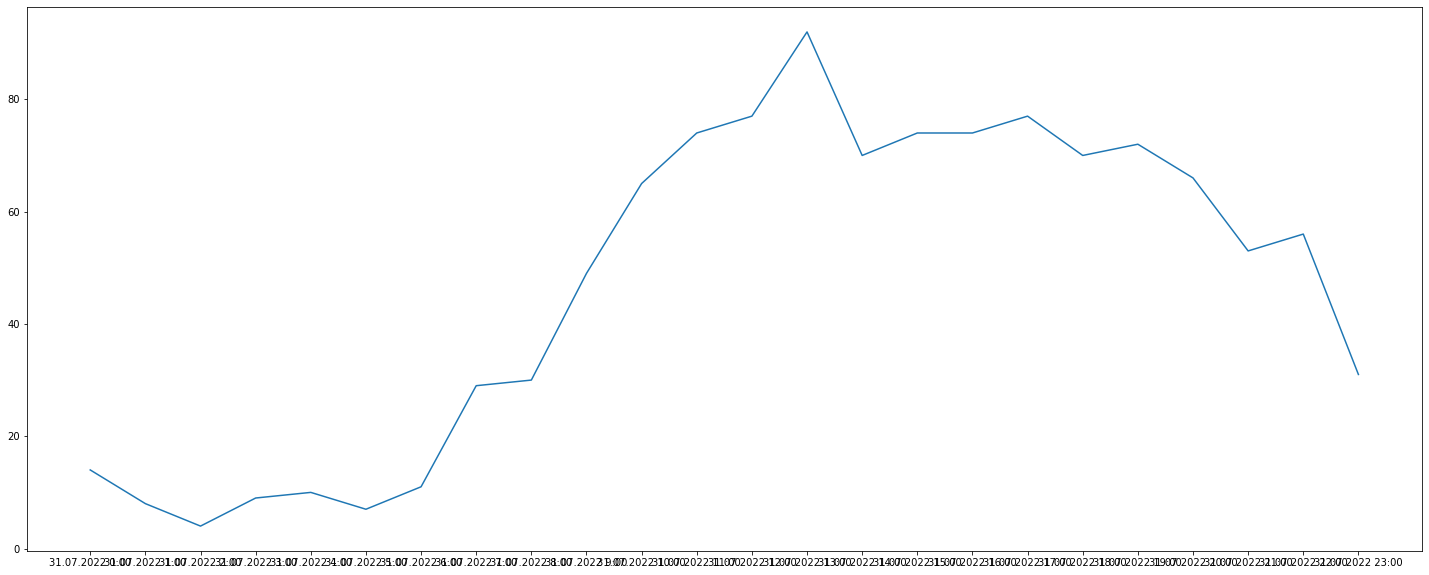

In [102]:
x2 = query_frame['hour_'][-24:]
y2 = query_frame['count(event)'][-24:]
plt.plot(x2, y2)
plt.show()